In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import time
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

%tensorflow_version 2.x
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dropout

TensorFlow 2.x selected.


# Utility functions

In [0]:
def normalize_value(val, max_val, min_val):
    '''
        The returns the normalized version of an value, given
        the maximum value and minimum value in the data_column

        Using formula:

        Norm value = (x_i - (a+b)/2) / ((a-b)/2)
    '''
    return (val - (max_val + min_val)/2) / ((max_val - min_val)/2)

def normalize_data(X_train, X_test):
    '''
        Normalizes the dataset to (-1, to 1); and uses ranges from the training
        data, to normalize the testing data.
    '''

    X_train_normalized = X_train[:, 0] # the first columns are just ones for constants
    X_test_normalized = X_test[:, 0]

    for i in range(1, X_train.shape[1]):
        max_val = np.max(X_train[:, i])
        min_val = np.min(X_train[:, i])

        col_normalized_train = [normalize_value(val, max_val, min_val) for val in X_train[:, i]] 
        col_normalized_test = [normalize_value(val, max_val, min_val) for val in X_test[:, i]]

        X_train_normalized = np.column_stack((X_train_normalized, col_normalized_train))
        X_test_normalized = np.column_stack((X_test_normalized, col_normalized_test))

    return X_train_normalized, X_test_normalized

def calc_msfe(y_actual, y_predictions):
    '''
        Calculates Mean Squared Forecast Error (MSFE) between the predicted and
        actual value.
    '''
    n = len(y_actual)
    errors = [(y_actual[i]-y_predictions[i])**2 for i in range(n)]
    return np.sum(errors)/n

def calc_historical_average_return_forecast(returns, num_out_sample):   
    '''
        Computes the historical average return forecast.
        The forecast is estimated as the average return of all the past time periods, as
        defined in teh equation above.
    '''
    forecasted_returns = [(np.sum(returns[:t])/t) for t in range(1, len(returns))]
    return forecasted_returns[((-1)*num_out_sample):]

def calc_r2_os(y_actual, y_predictions, benchmark_predictions):
    '''
        Computes the R2_os score for each model by comparing it with the MSFE of
        historical average return forecast
    '''
    msfe_i = calc_msfe(y_actual, y_predictions)
    msfe_0 = calc_msfe(y_actual, benchmark_predictions)
    return 1 - (msfe_i / msfe_0)

def calc_R2OS_and_p_value(e_HA, FC_HA, e_X, FC_X):

    # R2OS
    R2OS = 100*(1- (np.sum(np.power(e_X, 2)) / np.sum(np.power(e_HA, 2))))
    
    # P-value
    e_X_reshaped = e_X.reshape(e_X.shape[0], 1)
    FC_X_reshaped = FC_X.reshape(FC_X.shape[0], 1)
    f_i = np.power(e_HA, 2) - (np.power(e_X_reshaped,2) - np.power(FC_HA - FC_X_reshaped, 2))

    print('f_i shape: ', f_i.shape)
    results_i  = sm.OLS(f_i, np.ones((f_i.shape[0], 1))).fit()
    print('Frist fit')
    results_i = results_i.get_robustcov_results(cov_type='HAC',maxlags=0)
    print('Nwest errors')
    p_value = 1 - norm.cdf(results_i.tvalues[0], loc=0, scale=1)
    print('p_value found')
    return R2OS, p_value

# Model initialization

In [0]:
def initialize_model(n_lstm_units,
                     n_dropout,
                     input_shape):
    # building and compiling model
    # Initialising the RNN
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = n_lstm_units, return_sequences = True, 
                   input_shape = input_shape))
    model.add(Dropout(n_dropout))


    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = n_lstm_units, return_sequences = True))
    model.add(Dropout(n_dropout))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = n_lstm_units))
    model.add(Dropout(n_dropout))

    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

## Function to train model and generate forecasts

In [0]:
def generate_results_lstm_model(Y, X, FC_HA, n_in_sample, 
                     n_holdout_sample, n_forecast_evaluation, verbose=False):
    
    ## values for attributes of the model
    n_dropout = 0.2
    n_lstm_units = 50
    n_epochs = 100
    n_batch_size = 32
    
    # Splitting X into train and testing samples
    X_train = X[:n_in_sample]
    X_out_sample = X[n_in_sample:]
    X_val = X_out_sample[:n_holdout_sample]
    X_test = X_out_sample[n_holdout_sample:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Splitting Y into train and testing samples
    Y_train = Y[:n_in_sample]
    Y_out_sample = Y[n_in_sample:]
    Y_val = Y_out_sample[:n_holdout_sample]
    Y_test = Y_out_sample[n_holdout_sample:]

    # input shape
    input_shape = (X_train.shape[1], 1)
    model = initialize_model(n_lstm_units,
                        n_dropout,
                        input_shape)
    # fitting model
    model.fit(X_train, Y_train, 
                    epochs = n_epochs, batch_size = n_batch_size, 
                    validation_data=(X_val, Y_val), verbose=verbose)
    

    # generating predictions
    predictions = model.predict(X_test)

    # calculaitng error scores
    r2_os = calc_r2_os(Y_test, 
                        predictions, 
                        FC_HA)

    # Calculaing P-value
    FC_MODEL = predictions
    actual = np.reshape(Y_test, (Y_test.shape[0], 1))
    FC_HA = FC_HA.reshape(-1, 1)
    e_HA = actual - FC_HA
    e_MODEL = np.kron(np.ones((1, FC_MODEL.shape[1])), actual) - FC_MODEL
    R2OS_percentage, p_value = calc_R2OS_and_p_value(e_HA, FC_HA, e_MODEL[:,0], FC_MODEL[:,0])

    print('Value estimated')

    results = {
        'model': model,
        'actual': Y_test,
        'forecasts': predictions,
        'R2OS': r2_os,
        'R2OS_percentage': R2OS_percentage,
        'p_value': p_value
    }

    return results

# Model performance on NYSE data (1926 to 2010) dataset used in Rapach et. al. (2013)

Train on 241 samples, validate on 120 samples
Epoch 1/100
241/241 [==============================] - 6s 25ms/sample - loss: 0.0080 - val_loss: 0.0014
Epoch 2/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0073 - val_loss: 0.0017
Epoch 3/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0072 - val_loss: 0.0014
Epoch 4/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0074 - val_loss: 0.0014
Epoch 5/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0074 - val_loss: 0.0015
Epoch 6/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0074 - val_loss: 0.0015
Epoch 7/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0074 - val_loss: 0.0015
Epoch 8/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0073 - val_loss: 0.0014
Epoch 9/100
241/241 [==============================] - 0s 2ms/sample - loss: 0.0075 - val_loss: 0.0014
Epoch 10/100
241/241 [====

,Model,R2OS,R2OS (%),p_value
0,RNN_LSTM,-0.0372,-3.7178,0.0806


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


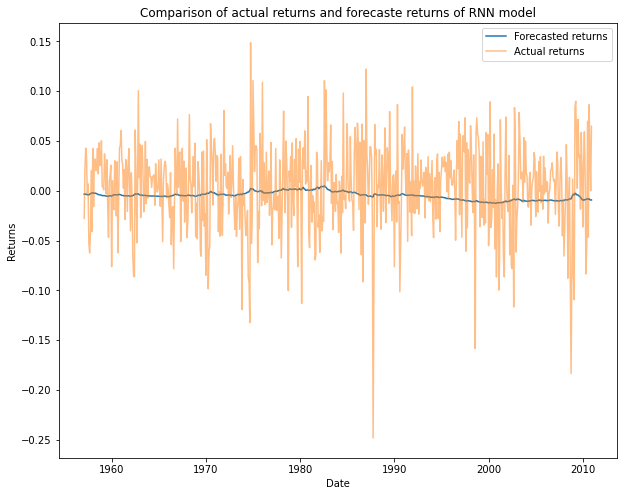

In [6]:
def generate_results_nyse_rapach_data(url_data, verbose=False):
    data = pd.read_excel(url_data, 'Monthly')
    data.head()

    # Equity premium


    idx_first = 671 # starting data 1926:11
    idx_last = 1679 # final date 2010:12

    timestamps = data.loc[idx_first:idx_last, 'Date (yyyymm)']

    market_return = np.array(data.loc[idx_first:idx_last, ['CRSP S&P 500 value-weighted return with dividends']]).flatten()
    r_f_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'Risk-free rate']) # risk free rate
    equity_premium = np.log(1+market_return)-np.log(1+r_f_lag) # log excess return

    #dividends
    d12=np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 dividends']) 
    #S7P 500 index
    sp500 = np.array(data.loc[idx_first:idx_last, 'S&P 500 index']) 
    # log dividend-price ratio
    dp = np.log(d12) - np.log(sp500) 
    # S&P 500 index, lagged 
    sp500_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'S&P 500 index']) # S&P 500 index, lagged 
    # log dividend yield
    dy = np.log(d12) - np.log(sp500_lag)
    # earnings
    e12 = np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 earnings'])
    # log earnings to price ratio
    ep = np.log(e12) - np.log(sp500)
    # log dividend-payout ratio
    de = np.log(d12) - np.log(e12)
    # volatility (SVAR)
    svar = np.array(data.loc[idx_first:idx_last, 'Monthly sum of squared daily returns on S&P 500 index'])
    # book to market ratio
    bm = np.array(data.loc[idx_first:idx_last, 'DJIA book-to-market value ratio'])
    # net equity issuing activity
    ntis=np.array(data.loc[idx_first:idx_last, 'Net equity expansion'])
    # t-bill raate
    tbl = np.array(data.loc[idx_first:idx_last, '3-month Treasury bill yield (secondary market)'])
    # long-term government bond yield
    lty = np.array(data.loc[idx_first:idx_last, 'Long-term government bond yield'])
    # long-term governmnent bond return
    ltr = np.array(data.loc[idx_first:idx_last, 'Long-term government bond return'])
    # term spread
    tms=lty-tbl
    # AAA-rated corporate bond yield
    aaa = np.array(data.loc[idx_first:idx_last, 'Moodys AAA-rated corporate bond yield'])
    # BAA-rated corporate bond yield
    baa = np.array(data.loc[idx_first:idx_last, 'Moodys BAA-rated corporate bond yield'])
    # Default yield spread
    dfy = baa-aaa
    # Long-term corporate bond return
    corpr = np.array(data.loc[idx_first:idx_last, 'Long-term corporate bond return'])
    # Default return spread
    dfr = corpr - ltr
    # Inflation, lagged(1926:11-2010:11)
    infl_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'CPI (all urban consumers) inflation rate'])
    # Combined arrays of all variable
                        
    econ = np.column_stack((dp, dy, ep, de, svar, bm, ntis, tbl, lty, ltr, tms, dfy, dfr, infl_lag))
    econ_sink = np.column_stack((dp, dy, ep, svar, bm, ntis, tbl, lty, ltr, dfy, dfr, infl_lag))

    Y = equity_premium[1:]
    X = econ[:-1, ]
    T = Y.shape[0]

    n_in_sample = (1946-1926)*12+1
    n_holdout_sample = (1956-1946)*12
    n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) 
    n_out_sample = n_holdout_sample + n_forecast_evaluation

    def change_number_to_date(timestamp):
        timestamp = str(timestamp)
        year = timestamp[:4]
        month = timestamp[4:6]
        str_timestamp = '{}-{}-01'.format(year, month)
        return str_timestamp

    timestamps = timestamps.apply(change_number_to_date)
    timestamps = pd.to_datetime(timestamps)
    timestamps = timestamps[n_in_sample + n_holdout_sample + 1:]
    timestamps = timestamps.reset_index()
    timestamps = timestamps['Date (yyyymm)']

    # historical average forecasts
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = np.array(FC_HA[n_holdout_sample:])

    results_lstm = generate_results_lstm_model(Y, X, FC_HA, n_in_sample, 
                     n_holdout_sample, n_forecast_evaluation, verbose)

    results_lstm['timestamps'] = timestamps
    results_lstm['FC_HA'] = FC_HA

    print('LSTM calculation completed')
    if verbose:
        df_results = pd.DataFrame({
            'Model': ['RNN_LSTM'],
            'R2OS': [results_lstm['R2OS']],
            'R2OS (%)': [results_lstm['R2OS_percentage']],
            'p_value': [results_lstm['p_value']]
        })

        print('\n\n')
        display(df_results.round(4))

        # Plotting graph
        plt.figure(figsize=(10, 8))
        plt.plot(timestamps, results_lstm['forecasts'], label='Forecasted returns')
        plt.plot(timestamps, results_lstm['actual'], label='Actual returns', alpha=0.5)
        plt.title('Comparison of actual returns and forecaste returns of RNN model')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()

    return results_lstm

# Driver
url_data = 'https://github.com/nik1997/capstone2020/blob/master/data/Returns_handbook_data.xls?raw=true'
results_nyse_original = generate_results_nyse_rapach_data(url_data, verbose=True)

# Model comparison between NYSE and NEPSE using data from 1997

In [0]:
def generate_1997_forecasts(url_data, verbose=False):
    
    data = pd.read_csv(url_data)
    data = data.dropna()
    data=data.reset_index()
    print('Shape of dataset: ', data.shape)

    # calculating log returns
    log_returns = np.log(1+np.array(data['returns']))

    # predictors
    svar = np.array(data['SVAR'])[:-1]
    infl = np.array(data['infl'])[:-1]
    gov_bond_yields = np.array(data['gov_bond_yields'])[:-1]
    treasury_yields = np.array(data['treasury_yields'])[:-1]
    term_spreads = gov_bond_yields - treasury_yields
    

    econ = np.column_stack((svar, infl, gov_bond_yields, treasury_yields, term_spreads))
    econ_sink = np.column_stack((svar, infl, gov_bond_yields, treasury_yields))
    predictors = ['svar', 'infl', 'gov_bond_yields', 'treasury_yields', 'term_spreads']

    # X_stan
    X = np.column_stack((svar, infl, gov_bond_yields, treasury_yields))

    Y = log_returns[1:]
    T = Y.shape[0]

    # other parameters
    n_in_sample = int(T * 0.8)  # In -sample period first 150 dataset
    n_holdout_sample = int(T * 0.05) # Hold out sample
    n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) # Forecast evaluation peroid
    n_out_sample = n_holdout_sample + n_forecast_evaluation

    # historical average forecasts
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = FC_HA[n_holdout_sample:]

    # timestamps
    timestamps = pd.to_datetime(data['Date'])
    timestamps = timestamps[n_in_sample + n_holdout_sample + 1:]
    timestamps = timestamps.reset_index()
    timestamps = timestamps['Date']

     # historical average forecasts
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = np.array(FC_HA[n_holdout_sample:])

    results_lstm = generate_results_lstm_model(Y, X, FC_HA, n_in_sample, 
                     n_holdout_sample, n_forecast_evaluation, verbose)

    results_lstm['timestamps'] = timestamps
    results_lstm['FC_HA'] = FC_HA

    print('LSTM calculation completed')
    if verbose:
        df_results = pd.DataFrame({
            'Model': ['RNN_LSTM'],
            'R2OS': [results_lstm['R2OS']],
            'R2OS (%)': [results_lstm['R2OS_percentage']],
            'p_value': [results_lstm['p_value']]
        })

        print('\n\n')
        display(df_results.round(4))

        # Plotting graph
        plt.figure(figsize=(10, 8))
        plt.plot(timestamps, results_lstm['forecasts'], label='Forecasted returns')
        plt.plot(timestamps, results_lstm['actual'], label='Actual returns')
        plt.title('Comparison of actual returns and forecaste returns of RNN model')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()
            
    return results_lstm

Shape of dataset:  (211, 9)
Train on 168 samples, validate on 10 samples
Epoch 1/100
168/168 [==============================] - 7s 44ms/sample - loss: 0.0025 - val_loss: 0.0028
Epoch 2/100
168/168 [==============================] - 0s 804us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 3/100
168/168 [==============================] - 0s 765us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 4/100
168/168 [==============================] - 0s 747us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 5/100
168/168 [==============================] - 0s 842us/sample - loss: 0.0025 - val_loss: 0.0028
Epoch 6/100
168/168 [==============================] - 0s 779us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 7/100
168/168 [==============================] - 0s 843us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 8/100
168/168 [==============================] - 0s 770us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 9/100
168/168 [==============================] - 0s 806us/sample - loss: 0.0024 - 

,Model,R2OS,R2OS (%),p_value
0,RNN_LSTM,-0.0244,-2.4372,0.9218


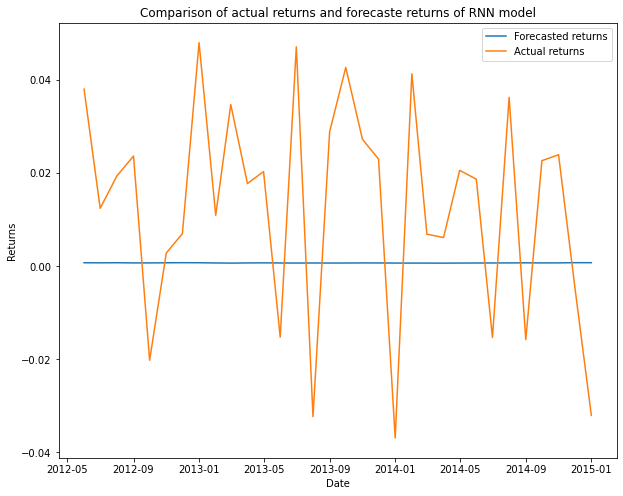

In [30]:
# Generating results for NYSE
results_nyse_1997 = generate_1997_forecasts('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nyse_data.csv', True)

NYSE


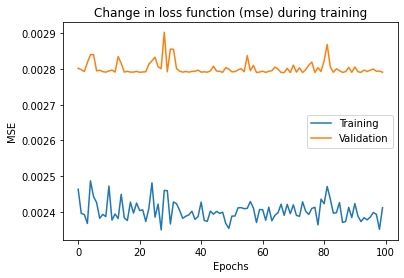

In [62]:
print("NYSE")
model = results_nyse_1997['model']
# Plotting the loss during training
plt.plot(model.history.history['loss'], label='Training')
plt.plot(model.history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Change in loss function (mse) during training')
plt.legend()
plt.show()

Shape of dataset:  (211, 8)
Train on 168 samples, validate on 10 samples
Epoch 1/100
168/168 [==============================] - 6s 38ms/sample - loss: 0.0047 - val_loss: 0.0106
Epoch 2/100
168/168 [==============================] - 0s 722us/sample - loss: 0.0048 - val_loss: 0.0106
Epoch 3/100
168/168 [==============================] - 0s 744us/sample - loss: 0.0046 - val_loss: 0.0106
Epoch 4/100
168/168 [==============================] - 0s 686us/sample - loss: 0.0046 - val_loss: 0.0106
Epoch 5/100
168/168 [==============================] - 0s 712us/sample - loss: 0.0046 - val_loss: 0.0106
Epoch 6/100
168/168 [==============================] - 0s 708us/sample - loss: 0.0046 - val_loss: 0.0106
Epoch 7/100
168/168 [==============================] - 0s 753us/sample - loss: 0.0046 - val_loss: 0.0106
Epoch 8/100
168/168 [==============================] - 0s 693us/sample - loss: 0.0045 - val_loss: 0.0106
Epoch 9/100
168/168 [==============================] - 0s 702us/sample - loss: 0.0046 - 

,Model,R2OS,R2OS (%),p_value
0,RNN_LSTM,-0.0072,-0.7207,0.7198


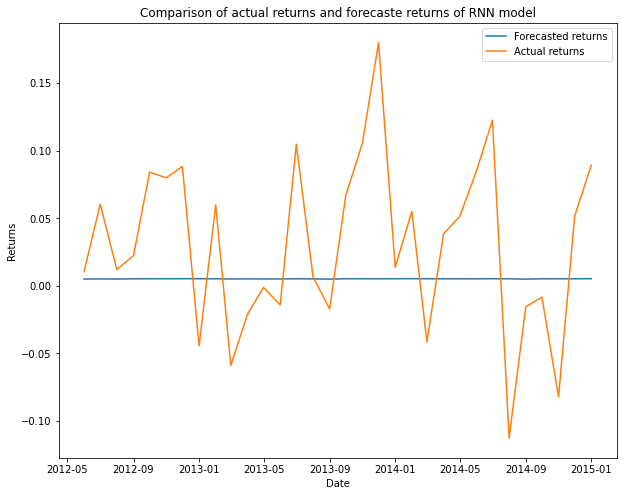

In [25]:
# Generating results for NEPSE
results_nepse_1997 = generate_1997_forecasts('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nepse_data.csv', True)

NEPSE


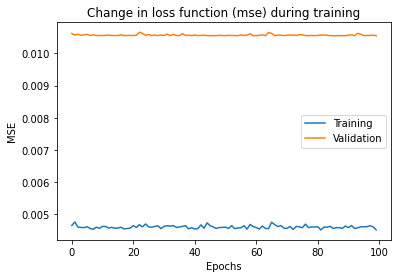

In [61]:
print("NEPSE")
model = results_nepse_1997['model']
plt.plot(model.history.history['loss'], label='Training')
plt.plot(model.history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Change in loss function (mse) during training')
plt.legend()
plt.show()